# The Soft Margin Linear SVM

**EE514: Data Analysis and Machine Learning**

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

Here we show how to solve the soft margin linear SVM by using the [CVXOPT](http://cvxopt.org) package to solve the corresponding quadratic program.

## Install CVXOPT

CVXOPT is a package for convex optimization. More Information on CVXOPT can be found at [cvxopt.org](https://cvxopt.org/).

In [ ]:
!pip3 install cvxopt

    100% |████████████████████████████████| 11.6MB 3.0MB/s 


## Import packages and define some utility functions

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import cvxopt
import cvxopt.solvers
import seaborn as sns

sns.set_style('white')

In [ ]:
def load_dataset(fn):
    data = np.load(fn)
    return data['X'], data['y']

def plot_dataset(X, y):
    figure(figsize=(8,6))
    positives = X[y==1]
    negatives = X[y==-1]
    scatter(positives[:,0], positives[:,1], s=100, c='b', marker='*', label='positives')
    scatter(negatives[:,0], negatives[:,1], s=60, c='r', marker='^', label='negatives')
    legend()
    show()
    
def plot_decision_function(df, X, y):
    
    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min
    
    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range
    
    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)
    
    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    
    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)
    
    
    # Plot the decision function
    figure(figsize=(8,6))
    contour(X0, X1, Y, levels=[-1,0,1], 
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')
    
    # Plot the data
    positives = X[y==1]
    negatives = X[y==-1]
    scatter(positives[:,0], positives[:,1], s=100, c='b', marker='*', label='positives')
    scatter(negatives[:,0], negatives[:,1], s=60, c='r', marker='^', label='negatives')
    legend()
    show()

## Implement the soft margin linear SVM

Formulate the soft margin problem as a quadratic program and solve it using CVXOPT.

In [ ]:
class SoftMarginSVM(object):
    
    def __init__(self, C=1.0):
        self.C = C
    
    def fit(self, X, y):
        n, m = X.shape
        mat = cvxopt.matrix
        
        # x = [w(m), b(1), slack(n)]
        
        
        # Create q for the linear part of the objective
        # w, b have no contribution
        # slack contributes with C
        #
        q = np.zeros(m+n+1)
        q[:m+1] = 0
        q[m+1:] = self.C 
        q = mat(q, (q.shape[0], 1))
        
        # Create P for the quadratic part
        # w has a contribution of 1
        # slack and b have no contribution
        #
        P = np.zeros(m+n+1)
        P[:m] = 1.0
        P = np.diag(P)
        P = mat(P)
        
        # Create h for the right hand side of the inequality constraints
        # n equations for margin constraints 
        # n equations for slack variables
        #
        h = np.zeros(2*n)
        h[:n] = -1.0
        h = mat(h, (h.shape[0], 1))
        
        # Create G matrix for the left hand side of the inequality constraints
        # has 2n rows, n for margin constraints and n for slack variables
        # has m+1+n columns for w, b, and slack variables
        #
        G11 = -y[:,np.newaxis] * X
        G12 = -y[:,np.newaxis]
        G13 = -np.eye(n)
        G21 = np.zeros((n, m))
        G22 = np.zeros((n, 1))
        G23 = -np.eye(n)
        G = np.bmat([[G11, G12, G13], [G21, G22, G23]])
        G = mat(G)        
    
        # Solve QP
        solution = cvxopt.solvers.qp(P, q, G, h)
        
        # Check to make sure we have the optimal solution
        if solution['status'] != 'optimal':
            raise ValueError('infeasible')
        
        # Assign model parameters w, b
        x = np.array(solution['x']).ravel()
        self.w = x[:m]
        self.b = x[m]
        self.slack = x[m+1:]
        
    def decision_function(self, X):
        return dot(X, self.w) + self.b
    
    def predict(self, X):
        return np.where(self.decision_function(X) > 0, 1, -1)
    
    @property
    def margin(self):
        return 1.0 / np.sqrt(np.dot(self.w, self.w))

## Load the separable dataset

First we download a pre-made linearly separable dataset.

In [ ]:
!curl -O# http://www.eeng.dcu.ie/~mcguinne/data/ee514/separable.npz

######################################################################## 100.0%


Then load the dataset and plot it.

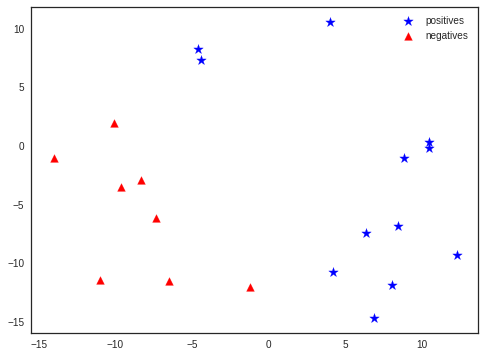

In [ ]:
X, y = load_dataset('separable.npz')
plot_dataset(X, y)

## Fit SVM a soft margin SVM with $C = 1$

The soft margin solution with $C=1$ is identical to the hard margin solution.

     pcost       dcost       gap    pres   dres
 0: -1.6149e+01  3.2843e+01  1e+02  3e+00  5e+01
 1:  9.3307e+00 -7.5598e+00  3e+01  5e-01  6e+00
 2:  1.8682e+00 -1.9639e+00  5e+00  9e-02  1e+00
 3:  2.1729e-01 -1.5842e-02  2e-01  1e-15  6e-16
 4:  8.3390e-02  4.0453e-02  4e-02  7e-16  2e-16
 5:  7.3547e-02  6.4140e-02  9e-03  5e-16  6e-16
 6:  6.8066e-02  6.7346e-02  7e-04  5e-16  7e-16
 7:  6.7669e-02  6.7657e-02  1e-05  6e-16  3e-16
 8:  6.7662e-02  6.7662e-02  1e-07  5e-16  6e-16
 9:  6.7662e-02  6.7662e-02  1e-09  8e-16  9e-16
Optimal solution found.


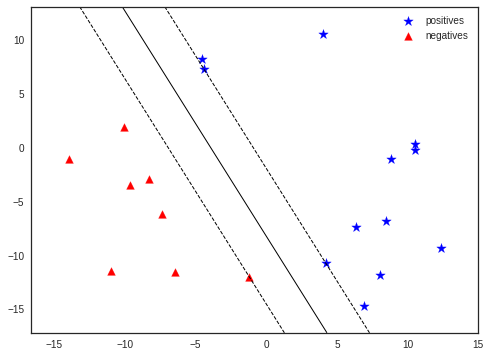

In [ ]:
svm = SoftMarginSVM(C=1)
svm.fit(X, y)
plot_decision_function(svm.decision_function, X, y)

The total slack is (effectively) zero, meaning no training examples violate the margin.

In [ ]:
np.sum(svm.slack)

5.177979016921687e-10

## Reduce penalty for violating the margin $C = 0.01$

This will produce a wider margin at the cost of some examples violating the margin.

In [ ]:
svm = SoftMarginSVM(C=0.05)
svm.fit(X, y)
plot_decision_function(svm.decision_function, X, y)

     pcost       dcost       gap    pres   dres
 0:  5.7235e-02  3.3550e+00  7e+01  2e+00  2e+02
 1:  1.3453e+00 -1.5125e+00  3e+00  5e-02  5e+00
 2:  5.7712e-01 -1.9675e-01  8e-01  1e-02  1e+00
 3:  1.2655e-01  2.2648e-02  1e-01  1e-03  1e-01
 4:  7.6510e-02  5.3222e-02  2e-02  3e-04  2e-02
 5:  6.4444e-02  6.1988e-02  2e-03  1e-05  1e-03
 6:  6.3119e-02  6.2948e-02  2e-04  5e-07  4e-05
 7:  6.3053e-02  6.3046e-02  7e-06  7e-09  7e-07
 8:  6.3052e-02  6.3051e-02  3e-07  6e-11  6e-09
 9:  6.3052e-02  6.3052e-02  3e-09  6e-13  6e-11
Optimal solution found.


The resulting margin is wider and violated by only one example. The slack is now non-zero to account for this example.

In [ ]:
np.sum(svm.slack)

0.5220642856579073

## Load non-separable dataset

The hard margin SVM cannot handle linearly inseparable problems. The soft margin version can deal with these. Here we download a pre-made inseparable dataset and load it in.

In [ ]:
!curl -O# http://www.eeng.dcu.ie/~mcguinne/data/ee514/nonseparable.npz

######################################################################## 100.0%


Then load the dataset and plot it.

In [ ]:
X, y = load_dataset('nonseparable.npz')
plot_dataset(X, y)

## Soft margin SVM on inseparable data with $C=1$

     pcost       dcost       gap    pres   dres
 0: -1.1247e+01  3.5486e+01  1e+02  3e+00  9e+00
 1:  1.6390e+01  3.1016e-02  2e+01  3e-01  9e-01
 2:  7.9658e+00  5.6835e+00  3e+00  3e-02  1e-01
 3:  7.2153e+00  6.9675e+00  3e-01  3e-03  7e-03
 4:  7.1090e+00  7.0917e+00  2e-02  8e-05  2e-04
 5:  7.1025e+00  7.1015e+00  1e-03  1e-06  3e-06
 6:  7.1023e+00  7.1022e+00  9e-05  4e-09  1e-08
 7:  7.1023e+00  7.1023e+00  2e-06  3e-11  7e-11
Optimal solution found.


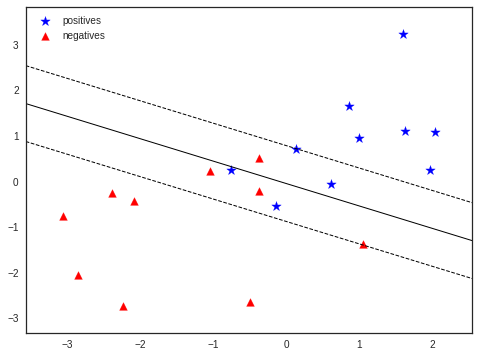

In [ ]:
svm = SoftMarginSVM(C=1)
svm.fit(X, y)
plot_decision_function(svm.decision_function, X, y)

The SVM finds the optimal tradeoff between a good margin and low slack for the given $C$ parameter. As expected, the slack is positive.

In [ ]:
print(sum(svm.slack))

6.204580536447176


## Soft margin SVM on inseparable data with $C=100$

Increasing the penalty for violating the margin results in a narrower margin but lower slack coefficients.

In [ ]:
svm = SoftMarginSVM(C=100)
svm.fit(X, y)
plot_decision_function(svm.decision_function, X, y)

     pcost       dcost       gap    pres   dres
 0: -1.5658e+05  3.8783e+04  1e+05  2e+02  1e+00
 1:  3.3831e+02 -2.2374e+03  1e+04  8e+00  6e-02
 2:  1.3489e+03  2.5954e+02  1e+03  2e-01  2e-03
 3:  6.4402e+02  4.1087e+02  3e+02  4e-02  3e-04
 4:  5.6328e+02  4.7396e+02  1e+02  1e-02  1e-04
 5:  5.6067e+02  5.3056e+02  3e+01  2e-03  1e-05
 6:  5.4674e+02  5.4616e+02  6e-01  3e-05  3e-07
 7:  5.4641e+02  5.4641e+02  6e-03  3e-07  3e-09
 8:  5.4641e+02  5.4641e+02  6e-05  3e-09  3e-11
Optimal solution found.


In [ ]:
print(sum(svm.slack))

5.430734955734782


## Soft margin SVM on inseparable data with $C=0.1$

Reducing $C$ gives a wider margin but higher slack coefficients.

In [ ]:
svm = SoftMarginSVM(C=0.1)
svm.fit(X, y)
plot_decision_function(svm.decision_function, X, y)

     pcost       dcost       gap    pres   dres
 0:  3.5860e-01  7.5546e+00  9e+01  2e+00  5e+01
 1:  3.2862e+00 -6.6175e-01  4e+00  4e-02  8e-01
 2:  1.0705e+00  7.7534e-01  3e-01  3e-16  4e-16
 3:  9.3675e-01  8.6635e-01  7e-02  2e-16  2e-16
 4:  9.1231e-01  8.9575e-01  2e-02  1e-16  1e-15
 5:  9.0446e-01  9.0208e-01  2e-03  2e-16  2e-15
 6:  9.0313e-01  9.0305e-01  9e-05  2e-16  3e-15
 7:  9.0310e-01  9.0309e-01  2e-05  2e-16  1e-15
 8:  9.0309e-01  9.0309e-01  2e-07  1e-16  2e-15
Optimal solution found.


In [ ]:
print(sum(svm.slack))

7.592997560664159


## Exercises

- Experiment with using the [soft margin linear SVM implementation in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) on the above datasets.

In [ ]:
from sklearn.svm import LinearSVC

#...

- Try using the `SoftMarginSVM` on higher dimensional data generated with scikit-learn's [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function. 
- Calculate training error

In [ ]:
from sklearn.datasets import make_classification


X, y = make_classification(n_samples=100, n_features=20)

# Transform target variable from [0, 1] to [-1, +1]
y = 2*y - 1